## Generative Adversarial Network

- Generate data to simulate each student in each exam (midterms and final)
- The goal is to generate the behavior of 100 other students (10 for each original student)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

def normalize_df(df):
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Normalize all columns except for any non-numeric columns (e.g., strings)
    numeric_columns = df.select_dtypes(include=['number']).columns
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    return df

df = pd.read_csv('./data/dataframes/S1/S1_midterm_1_averaged.csv')

#drop nan values
df = df.dropna()

#normalize the data
df = normalize_df(df)

In [11]:
df.describe()

,ACC_1,ACC_2,ACC_3,BVP_1,EDA_1,HR_1,TEMP_1
count,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000
mean,0.330526,0.547341,0.623323,0.653371,0.111937,0.335446,0.629657
std,0.212841,0.245714,0.247132,0.024148,0.184640,0.191349,0.355062
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.162258,0.430908,0.466803,0.651762,0.004777,0.192624,0.176282
50%,0.290946,0.509255,0.606843,0.653333,0.053915,0.295119,0.817308
75%,0.521872,0.707060,0.879900,0.654804,0.072342,0.428603,0.903846
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
def reduce_to_two_components(df):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)
    
    # Fit PCA to the data and transform the DataFrame
    reduced_data = pca.fit_transform(df)
    
    # Create a new DataFrame with reduced data
    reduced_df = pd.DataFrame(reduced_data, columns=['Feature1', 'Feature2'])
    
    return reduced_df

In [25]:
# Load your dataset into a pandas DataFrame (replace with your own data)
# For this example, we'll generate a simple toy dataset.
#data = {'Feature1': np.random.randn(1000),
#        'Feature2': np.random.randn(1000)}
#df = pd.DataFrame(data)

from tensorflow.keras.regularizers import l2


num_features = 7

# Define the GAN architecture
def build_generator(latent_dim, output_dim):
    model = Sequential()
    model.add(Dense(32, input_dim=latent_dim, kernel_regularizer=l2(0.01), activation='relu'))
    #model.add(Dense(32, input_dim=latent_dim, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    return model

def build_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Set the dimensions of the random noise vector
latent_dim = 20

# Build and compile the models
generator = build_generator(latent_dim, num_features)
discriminator = build_discriminator(num_features)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training the GAN
epochs = 10000
batch_size = 128

for epoch in range(epochs):
    # Train the discriminator
    idx = np.random.randint(0, df.shape[0], batch_size)
    real_data = df.iloc[idx]
    noise = np.random.randn(batch_size, latent_dim)
    fake_data = generator.predict(noise)
    
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.randn(batch_size, latent_dim)
    valid_labels = np.ones((batch_size, 1))
    
    g_loss = gan.train_on_batch(noise, valid_labels)

    # Print progress
    print(f"Epoch {epoch}/{epochs} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")

# Generate new data using the trained generator
num_generated_samples = 1000
noise = np.random.randn(num_generated_samples, latent_dim)
generated_data = generator.predict(noise)

# Convert the generated data into a DataFrame
generated_df = pd.DataFrame(generated_data, columns=df.columns)

# Reduce dataframes using pca

generated_df_reduced = reduce_to_two_components(generated_df)
df_reduced = reduce_to_two_components(df)

4/4 [==============================] - 0s 4ms/step
Epoch 0/10000 [D loss: 0.7256] [G loss: 0.8684]
4/4 [==============================] - 0s 4ms/step
Epoch 1/10000 [D loss: 0.7185] [G loss: 0.8938]
4/4 [==============================] - 0s 6ms/step
Epoch 2/10000 [D loss: 0.7219] [G loss: 0.8748]
4/4 [==============================] - 0s 6ms/step
Epoch 3/10000 [D loss: 0.7173] [G loss: 0.9133]
4/4 [==============================] - 0s 4ms/step
Epoch 4/10000 [D loss: 0.7268] [G loss: 0.9137]
4/4 [==============================] - 0s 5ms/step
Epoch 5/10000 [D loss: 0.7239] [G loss: 0.8987]
4/4 [==============================] - 0s 5ms/step
Epoch 6/10000 [D loss: 0.7237] [G loss: 0.8993]
4/4 [==============================] - 0s 4ms/step
Epoch 7/10000 [D loss: 0.7192] [G loss: 0.8948]
4/4 [==============================] - 0s 5ms/step
Epoch 8/10000 [D loss: 0.7321] [G loss: 0.9097]
4/4 [==============================] - 0s 5ms/step
Epoch 9/10000 [D loss: 0.7138] [G loss: 0.9000]
4/4 [=====

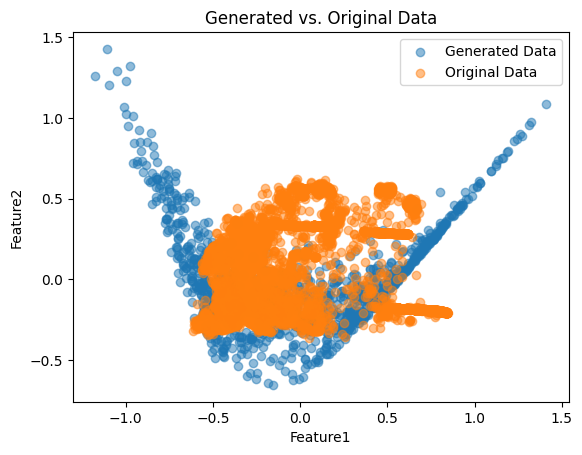

In [26]:
# Evaluate the performance (you can replace this with your own evaluation metrics)
# For example, you can compare generated_df with your original df using various statistical measures.

# Visualize the generated data
plt.scatter(generated_df_reduced['Feature1'], generated_df_reduced['Feature2'], alpha=0.5, label='Generated Data')
plt.scatter(df_reduced['Feature1'], df_reduced['Feature2'], alpha=0.5, label='Original Data')
plt.legend()
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Generated vs. Original Data')
plt.show()

In [29]:
generated_df.describe()

,ACC_1,ACC_2,ACC_3,BVP_1,EDA_1,HR_1,TEMP_1
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.189422,0.630217,0.851986,0.650649,0.084159,0.336170,0.530158
std,0.097066,0.291503,0.192732,0.170415,0.226853,0.147782,0.387643
min,0.027725,0.308557,0.472025,0.263805,-0.236598,0.105466,-0.210643
25%,0.123980,0.379862,0.721494,0.535752,-0.086653,0.215440,0.165729
50%,0.163306,0.543512,0.821021,0.626716,0.015941,0.287877,0.530801
75%,0.225301,0.812375,0.945651,0.746954,0.200062,0.434868,0.830375
max,0.640165,1.764828,1.619818,1.321753,1.015986,0.858955,1.670958


In [28]:
df.describe()

,ACC_1,ACC_2,ACC_3,BVP_1,EDA_1,HR_1,TEMP_1
count,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000
mean,0.330526,0.547341,0.623323,0.653371,0.111937,0.335446,0.629657
std,0.212841,0.245714,0.247132,0.024148,0.184640,0.191349,0.355062
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.162258,0.430908,0.466803,0.651762,0.004777,0.192624,0.176282
50%,0.290946,0.509255,0.606843,0.653333,0.053915,0.295119,0.817308
75%,0.521872,0.707060,0.879900,0.654804,0.072342,0.428603,0.903846
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Fazer um teste de normalidade Shapiro-wilk e depois escolher um teste adequado para comparar cada uma das colunas do dataset

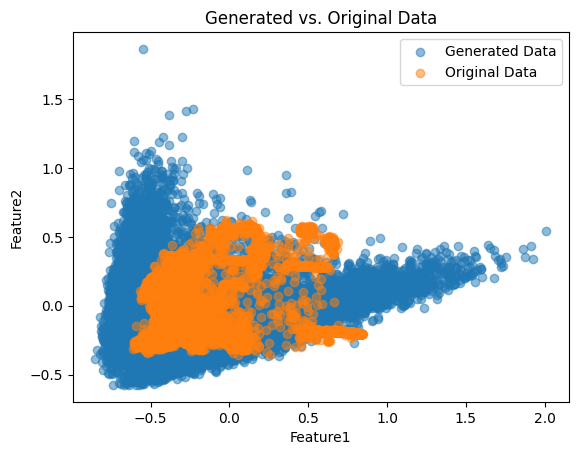

In [5]:
# Evaluate the performance (you can replace this with your own evaluation metrics)
# For example, you can compare generated_df with your original df using various statistical measures.

# Visualize the generated data
plt.scatter(generated_df_reduced['Feature1'], generated_df_reduced['Feature2'], alpha=0.5, label='Generated Data')
plt.scatter(df_reduced['Feature1'], df_reduced['Feature2'], alpha=0.5, label='Original Data')
plt.legend()
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Generated vs. Original Data')
plt.show()